In [1]:
import json
import pandas as pd
from yome import Session
from yome.models import *
from yome.util import to_df
import re
from sqlalchemy.orm import aliased
import itertools as it
import seaborn as sns
from IPython.display import HTML

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
from mpl_recipes import mpl_setup
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [4]:
session = Session()

# Psuedogenes 

In [5]:
# Genes maked pseudo in EcoGene
ecogene_pseudo = (
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoGene')
    .filter(KnowledgebaseFeature.feature_type == 'is_pseudogene')
    .filter(KnowledgebaseFeature.feature == 't')
)

In [6]:
ecogene_pseudo.count()

0

# Genes without b-number

In [46]:
# Genes b4309 pseudo in EcoGene
no_b_number = to_df(
    session.query(KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('kb_name'))
    .join(Knowledgebase)
    .filter(KnowledgebaseGene.gene_id == None)
)

In [47]:
no_b_number.groupby('kb_name').agg('count')

,primary_name,annotation_quality
kb_name,,
EcoCyc,55,55


# Find locus tags with multiple genes

In [41]:
KnowledgebaseGene2 = aliased(KnowledgebaseGene)

In [42]:
duplicates = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene2.primary_name.label('primary_name2'),
                  Knowledgebase.name)
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(KnowledgebaseGene2, KnowledgebaseGene2.gene_id == Gene.id)
    .join(Knowledgebase, KnowledgebaseGene.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene2.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene.id != KnowledgebaseGene2.id)
)

In [43]:
duplicates

,locus_id,primary_name,primary_name2,name
0,b3504,yhiS_2,yhiS_1,EcoCyc
1,b0240,crl_1,crl_2,EcoCyc
2,b0240,crl_2,crl_1,EcoCyc
3,b3504,yhiS_1,yhiS_2,EcoCyc


# Kbase comparison plot
NOTE: 55 EcoCyc genes without a locus tag and 4 EcoCyc genes with duplicated locud tags are ignored in this plot

In [29]:
kbases = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'))
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
)

In [30]:
levels = {
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
    None: 4
}

In [31]:
# remove duplicate genes
d = kbases.set_index(['locus_id', 'knowledgebase_name'])
d = d[~d.index.duplicated(keep='first')]
d = d.drop('primary_name', axis=1).unstack()
d.columns = d.columns.droplevel(0)
knowledgebase_names = list(d.columns)
dfp = d.applymap(lambda x: levels[x]).sort_values(by=list(d.columns))
dfp.head()

knowledgebase_name,EcoCyc,EcoGene,RefSeq,UniProt,iJL1678b
locus_id,,,,,
b0229,0,0,1,2,4
b0230,0,0,1,2,4
b0235,0,0,1,2,4
b0236,0,0,1,2,4
b0263,0,0,1,2,4


In [32]:
# create bars based on consecutive colors
last_value = {kbase: None for kbase in knowledgebase_names}
bars = {kbase: [] for kbase in knowledgebase_names}
for locus_tag, row in dfp.iterrows():
    for kbase, value in row.iteritems():
        if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
            bars[kbase].append({'value': value, 'height': 1})
            last_value[kbase] = value
        else:
            bars[kbase][-1]['height'] += 1

In [84]:
colors = {
    0: [ 0.85453713,  0.22957019,  0.27623218,  1.        ],
    1: [ 0.9170408 ,  0.56061475,  0.58722664,  1.        ],
    2: [ 0.57653009,  0.72175186,  0.76633449,  1.        ],
    3: [ 0.24715576,  0.49918708,  0.57655991,  1.        ], 
    4: [ 0.6,         0.6,         0.6,         1.        ],
}

[array([ 0.85453713,  0.22957019,  0.27623218,  1.        ]),
 array([ 0.9170408 ,  0.56061475,  0.58722664,  1.        ]),
 array([ 0.98157711,  0.90242499,  0.90833474,  1.        ]),
 array([ 0.95,  0.95,  0.95,  1.  ]),
 array([ 0.91661578,  0.95155452,  0.9622806 ,  1.        ]),
 array([ 0.57653009,  0.72175186,  0.76633449,  1.        ]),
 array([ 0.24715576,  0.49918708,  0.57655991,  1.        ])]

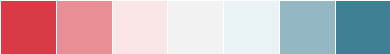

In [85]:
pal = sns.diverging_palette(10, 220, sep=80, n=7)
sns.palplot(pal)
pal

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


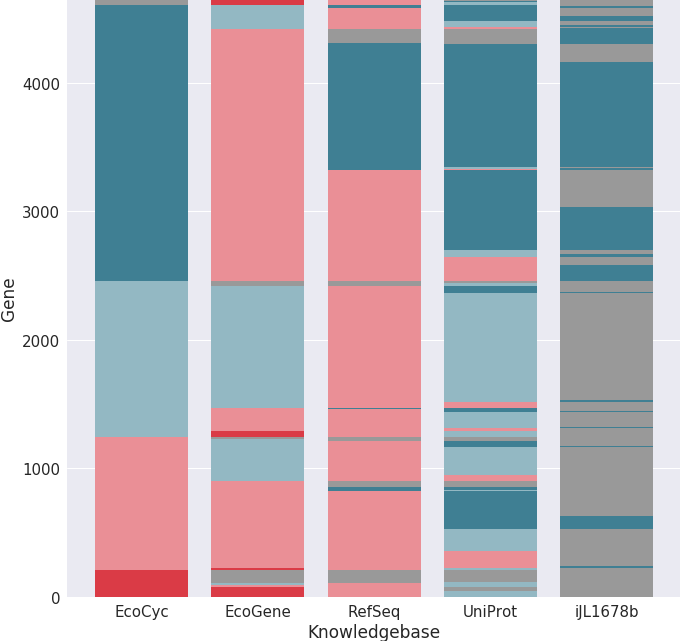

In [86]:
fig, ax = plt.subplots(figsize=(11, 11))
last_heights = [0 for _ in knowledgebase_names]
for bar_list in it.zip_longest(*bars.values()):
    left = [x + 0.1 for x in range(len(knowledgebase_names))]
    height = [x['height'] if x is not None else 0 for x in bar_list]
    bottom = last_heights
    last_heights = [x + y for x, y in zip(height, last_heights)]
    color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
    ax.bar(left, height, bottom=bottom, color=color, linewidth=0)
ax.set_xlabel('Knowledgebase')
ax.set_ylabel('Gene')
ax.xaxis.set_ticks([x + 0.1 for x in range(len(dfp.columns))])
ax.xaxis.set_ticklabels(dfp.columns)

# All information for a gene

In [ ]:
# Get TBD genes for EcoGene but high for Eco
report = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'),
                  KnowledgebaseFeature.feature_type,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Gene.locus_id == 'b1779')
)

In [69]:
# Genes maked pseudo in EcoGene
report = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'),
                  KnowledgebaseFeature.feature_type,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Gene.locus_id == 'b1779')
)

In [70]:
res = report[0]
res.knowledgebase_name = b1779.apply(lambda row: f"{row['knowledgebase_name']} ({row['annotation_quality']})", axis=1)
res = res.drop(['locus_id', 'primary_name', 'annotation_quality'], axis=1)
res = res.set_index(['knowledgebase_name', 'feature_type'])
s = res.style.set_properties(**{'text-align': 'left'})
HTML(s.render())